In [42]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm
import sklearn

import zipfile
import os

from helper_functions import *

import tensorflow as tf
import tensorflow_decision_forests as tfdf

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [44]:
full_data = pd.read_csv('cook_county_train.csv')
full_data.drop(['PIN', 'Construction Quality', 'Site Desirability', 'Other Improvements', 'Deed No.',
                   'Sale Half of Year', 'Sale Quarter of Year', 'Description', 'Modeling Group', 'Unnamed: 0', 'Estimate (Land)', 
                'Estimate (Building)'
               ], axis=1, inplace=True)
train, valid = train_val_split(full_data)

train.columns = [
    col.replace(" ", "_")          # remove spaces
       .replace("(", "")           # remove parentheses
       .replace(")", "")
       .replace("-", "_")          # replace dashes with underscores
       .replace("/", "_")          # replace slashes with underscores
    for col in train.columns
]
valid.columns = [
    col.replace(" ", "_")          # remove spaces
       .replace("(", "")           # remove parentheses
       .replace(")", "")
       .replace("-", "_")          # replace dashes with underscores
       .replace("/", "_")          # replace slashes with underscores
    for col in train.columns
]
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label='Sale_Price', task=tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid, label = 'Sale_Price', task = tfdf.keras.Task.REGRESSION)

In [45]:
max_depth_options = [5, 10, 15, 20, None]
results = {}
models = []
for max_depth in max_depth_options:
    print(f"\nTraining with max_depth = {max_depth}")
    model = tfdf.keras.RandomForestModel(
        task=tfdf.keras.Task.REGRESSION,
        max_depth=max_depth,
        verbose=0
    )
    
    model.compile(metrics=["RootMeanSquaredError"])
    
    model.fit(train_ds, verbose=0)
    
    evaluation = model.evaluate(valid_ds, verbose=0)
    rmse = evaluation[1]
    results[max_depth] = rmse
    print(f"Validation RMSE: {rmse:.4f}")
    models.append(model)

print("\nResults for each max_depth candidate:")
for depth, rmse in results.items():
    print(f"max_depth = {depth}: RMSE = {rmse:.4f}")


Training with max_depth = 5


I0000 00:00:1742871852.217891  890229 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742871852.219208  890229 kernel.cc:783] Collect training examples
I0000 00:00:1742871852.219223  890229 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742871852.223336  890229 kernel.cc:401] Number of batches: 164
I0000 00:00:1742871852.223345  890229 kernel.cc:402] Number of examples: 163833
I0000 00:00:1742871852.328167  890229 kernel.cc:802] Training dataset:
Number of records: 163833
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "Age" NUMERICAL mean:66.0186 min:1 max:169 sd:28.9488
	1: "Age_Decade" NUMERICAL mean:6.60186 min:0.1 max:16.9 sd:2.89488
	

Validation RMSE: 189495.7812

Training with max_depth = 10


I0000 00:00:1742871878.702485  890229 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742871878.702504  890229 kernel.cc:783] Collect training examples
I0000 00:00:1742871878.702510  890229 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742871878.702672  890229 kernel.cc:401] Number of batches: 164
I0000 00:00:1742871878.702678  890229 kernel.cc:402] Number of examples: 163833
I0000 00:00:1742871878.824726  890229 kernel.cc:802] Training dataset:
Number of records: 163833
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "Age" NUMERICAL mean:66.0186 min:1 max:169 sd:28.9488
	1: "Age_Decade" NUMERICAL mean:6.60186 min:0.1 max:16.9 sd:2.89488
	

Validation RMSE: 126702.3516

Training with max_depth = 15


I0000 00:00:1742871953.515383  890229 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742871953.515422  890229 kernel.cc:783] Collect training examples
I0000 00:00:1742871953.515443  890229 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742871953.515645  890229 kernel.cc:401] Number of batches: 164
I0000 00:00:1742871953.515652  890229 kernel.cc:402] Number of examples: 163833
I0000 00:00:1742871953.642496  890229 kernel.cc:802] Training dataset:
Number of records: 163833
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "Age" NUMERICAL mean:66.0186 min:1 max:169 sd:28.9488
	1: "Age_Decade" NUMERICAL mean:6.60186 min:0.1 max:16.9 sd:2.89488
	

Validation RMSE: 108823.7578

Training with max_depth = 20


I0000 00:00:1742872094.271523  890229 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742872094.271547  890229 kernel.cc:783] Collect training examples
I0000 00:00:1742872094.271553  890229 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742872094.271696  890229 kernel.cc:401] Number of batches: 164
I0000 00:00:1742872094.271702  890229 kernel.cc:402] Number of examples: 163833
I0000 00:00:1742872094.391911  890229 kernel.cc:802] Training dataset:
Number of records: 163833
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "Age" NUMERICAL mean:66.0186 min:1 max:169 sd:28.9488
	1: "Age_Decade" NUMERICAL mean:6.60186 min:0.1 max:16.9 sd:2.89488
	

Validation RMSE: 106005.0625

Training with max_depth = None


I0000 00:00:1742872313.398930  890229 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742872313.398966  890229 kernel.cc:783] Collect training examples
I0000 00:00:1742872313.398974  890229 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742872313.402477  890229 kernel.cc:401] Number of batches: 164
I0000 00:00:1742872313.402486  890229 kernel.cc:402] Number of examples: 163833
I0000 00:00:1742872313.529260  890229 kernel.cc:802] Training dataset:
Number of records: 163833
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "Age" NUMERICAL mean:66.0186 min:1 max:169 sd:28.9488
	1: "Age_Decade" NUMERICAL mean:6.60186 min:0.1 max:16.9 sd:2.89488
	

Validation RMSE: 108150.7578

Results for each max_depth candidate:
max_depth = 5: RMSE = 189495.7812
max_depth = 10: RMSE = 126702.3516
max_depth = 15: RMSE = 108823.7578
max_depth = 20: RMSE = 106005.0625
max_depth = None: RMSE = 108150.7578


In [53]:
num_trees_candidates = [50, 100, 300, 400]
results = {}
models = []

for num_trees in num_trees_candidates:
    print(f"\nTraining model with {num_trees} trees")

    model = tfdf.keras.RandomForestModel(
        num_trees=num_trees,
        task=tfdf.keras.Task.REGRESSION, 
        max_depth = 20,
        verbose=0
    )

    model.compile(metrics=["RootMeanSquaredError"])
    
    # Train the model (adjust epochs and batch size as needed)
    model.fit(train_ds, verbose=0)
    
    # Evaluate on validation dataset
    evaluation = model.evaluate(valid_ds, verbose=0)
    # Assume evaluation returns [loss, RMSE]
    rmse = evaluation[1]
    
    results[num_trees] = rmse
    models.append(model)
    print(f"Validation RMSE with {num_trees} trees: {rmse:.4f}")

print("\nResults for different numbers of trees:")
for num_trees, rmse in results.items():
    print(f"{num_trees} trees: RMSE = {rmse:.4f}")


Training model with 50 trees


I0000 00:00:1742872513.788772  890229 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742872513.788793  890229 kernel.cc:783] Collect training examples
I0000 00:00:1742872513.788799  890229 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742872513.791457  890229 kernel.cc:401] Number of batches: 164
I0000 00:00:1742872513.791469  890229 kernel.cc:402] Number of examples: 163833
I0000 00:00:1742872513.896630  890229 kernel.cc:802] Training dataset:
Number of records: 163833
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "Age" NUMERICAL mean:66.0186 min:1 max:169 sd:28.9488
	1: "Age_Decade" NUMERICAL mean:6.60186 min:0.1 max:16.9 sd:2.89488
	

Validation RMSE with 50 trees: 109754.7344

Training model with 100 trees


I0000 00:00:1742872551.702339  890229 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742872551.702359  890229 kernel.cc:783] Collect training examples
I0000 00:00:1742872551.702366  890229 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742872551.702518  890229 kernel.cc:401] Number of batches: 164
I0000 00:00:1742872551.702524  890229 kernel.cc:402] Number of examples: 163833
I0000 00:00:1742872551.808566  890229 kernel.cc:802] Training dataset:
Number of records: 163833
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "Age" NUMERICAL mean:66.0186 min:1 max:169 sd:28.9488
	1: "Age_Decade" NUMERICAL mean:6.60186 min:0.1 max:16.9 sd:2.89488
	

Validation RMSE with 100 trees: 107661.5859

Training model with 300 trees


I0000 00:00:1742872610.848624  890229 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742872610.848663  890229 kernel.cc:783] Collect training examples
I0000 00:00:1742872610.848688  890229 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742872610.848873  890229 kernel.cc:401] Number of batches: 164
I0000 00:00:1742872610.848880  890229 kernel.cc:402] Number of examples: 163833
I0000 00:00:1742872610.961140  890229 kernel.cc:802] Training dataset:
Number of records: 163833
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "Age" NUMERICAL mean:66.0186 min:1 max:169 sd:28.9488
	1: "Age_Decade" NUMERICAL mean:6.60186 min:0.1 max:16.9 sd:2.89488
	

Validation RMSE with 300 trees: 106005.0625

Training model with 400 trees


I0000 00:00:1742872794.825260  890229 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1742872794.825287  890229 kernel.cc:783] Collect training examples
I0000 00:00:1742872794.825292  890229 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1742872794.825449  890229 kernel.cc:401] Number of batches: 164
I0000 00:00:1742872794.825455  890229 kernel.cc:402] Number of examples: 163833
I0000 00:00:1742872794.929771  890229 kernel.cc:802] Training dataset:
Number of records: 163833
Number of columns: 51

Number of columns by type:
	NUMERICAL: 51 (100%)

Columns:

NUMERICAL: 51 (100%)
	0: "Age" NUMERICAL mean:66.0186 min:1 max:169 sd:28.9488
	1: "Age_Decade" NUMERICAL mean:6.60186 min:0.1 max:16.9 sd:2.89488
	

Validation RMSE with 400 trees: 105913.0234

Results for different numbers of trees:
50 trees: RMSE = 109754.7344
100 trees: RMSE = 107661.5859
300 trees: RMSE = 106005.0625
400 trees: RMSE = 105913.0234


In [57]:
best_model = models[3]

In [59]:
tfdf.model_plotter.plot_model_in_colab(best_model, tree_idx = 0, max_depth = 3)

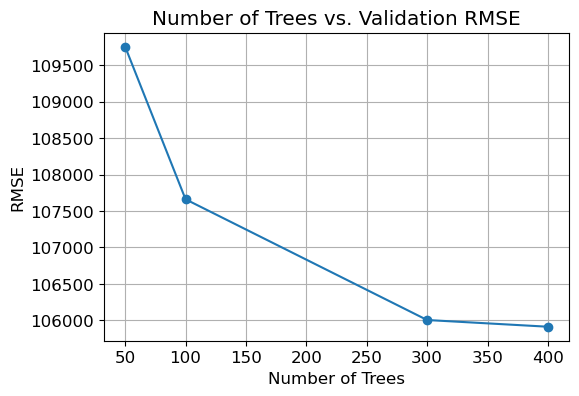

In [76]:
plt.figure(figsize=(6, 4))
num_trees_candidates = list(results.keys())
rmse_scores = list(results.values())
plt.plot(num_trees_candidates, rmse_scores, marker='o')
plt.xlabel("Number of Trees")
plt.ylabel("RMSE")
plt.title("Number of Trees vs. Validation RMSE")
plt.grid(True)
plt.show()

In [64]:
inspector = best_model.make_inspector()

In [68]:
evaluation = best_model.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

41/41 [==============================] - 9s 207ms/step - loss: 0.0000e+00 - root_mean_squared_error: 105913.0234
loss: 0.0000
root_mean_squared_error: 105913.0234


In [30]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


In [32]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("Building_Square_Feet" (1; #7), 155.0),
 ("Property_Class" (1; #37), 127.0),
 ("Fireplaces" (1; #13), 70.0),
 ("Pure_Market_Filter" (1; #38), 67.0),
 ("Latitude" (1; #25), 34.0),
 ("Age_Decade" (1; #1), 20.0),
 ("Age" (1; #0), 19.0),
 ("Roof_Material" (1; #41), 3.0),
 ("Census_Tract" (1; #9), 2.0),
 ("Central_Air" (1; #10), 2.0),
 ("Cathedral_Ceiling" (1; #8), 1.0)]

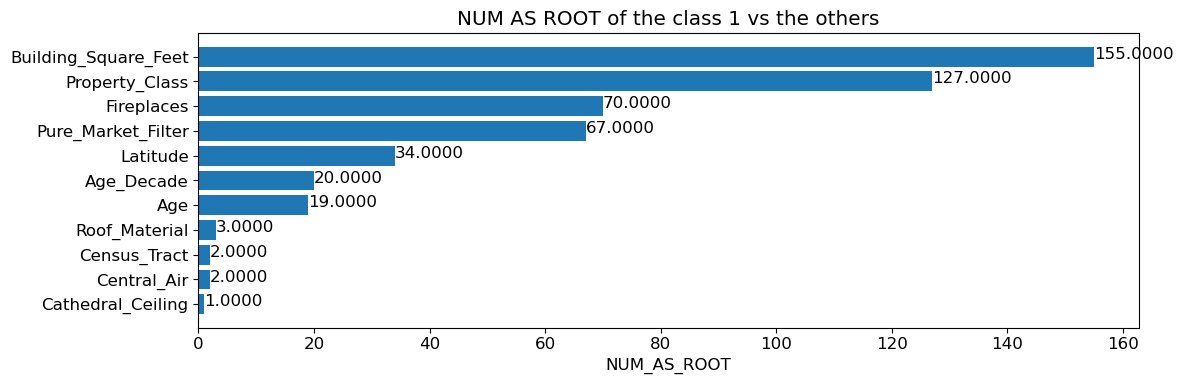

In [34]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()